# Importing

In [117]:
import pandas as pd
from pandas import DataFrame
from ast import literal_eval
import numpy as np
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
import openai
from openai.embeddings_utils import get_embedding
import tiktoken

In [118]:
# embedding model parameters
embedding_model = "text-embedding-ada-002"
embedding_encoding = "cl100k_base"  # this the encoding for text-embedding-ada-002
max_tokens = 8000  # the maximum for text-embedding-ada-002 is 8191

In [119]:
stop_words = set(stopwords.words('english'))

stop_words.add("module")
stop_words.add("course")
stop_words.add("problem")
stop_words.add("use")
stop_words.add("model")
stop_words.add("solution")
stop_words.add("solve")
stop_words.add("analyze")
stop_words.add("example")
stop_words.add("application")
stop_words.add("computer")
stop_words.add("computers")
stop_words.add("zero")
stop_words.add("one")
stop_words.add("two")
stop_words.add("three")
stop_words.add("four")
stop_words.add("five")
stop_words.add("six")
stop_words.add("seven")
stop_words.add("eight")
stop_words.add("nine")
stop_words.add("x")
stop_words.add("c")
stop_words.add("k")
stop_words.add("l")
stop_words.add("b")
stop_words.add("go")
stop_words.add("constraint")
stop_words.add("get")
stop_words.add("ok")
stop_words.add("uh")
stop_words.add("shift")
stop_words.add("see")
stop_words.add("give")
stop_words.add("take")
stop_words.add("right")
stop_words.add("know")
stop_words.add("want")
stop_words.add("may")
stop_words.add("way")
stop_words.add("say")
stop_words.add("let")
stop_words.add("thing")
stop_words.add("look")
stop_words.add("need")
stop_words.add("would")
stop_words.add("try")
stop_words.add("back")
stop_words.add("also")
stop_words.add("must")
stop_words.add("okay")
stop_words.add("talk")
stop_words.add("well")
stop_words.add("like")
stop_words.add("basically")
stop_words.add("maybe")

In [120]:
dataPaths = [
  "input/600_trans.tsv",
  "input/601_trans.tsv",
  "input/603_trans_3.tsv",
  "input/604_trans.tsv",
  "input/614_trans.tsv"
]

data = None

for dataFile in dataPaths:
  data = pd.concat([data, pd.read_csv(dataFile, sep='\t', header=0, encoding='utf-8')], ignore_index=True)

# Helper utilities

In [121]:
def clean_text(input: str) -> str:
    """
    Clean the text by removing special characters, and digits from the input string.
    """
    import re

    if input == "nan":
        return ""
    return re.sub(
        r"[^a-zA-Z]+",
        " ",
        input.replace("\\'", ""),
    )

In [122]:
def split_camel_case(df: DataFrame, col: str) -> DataFrame:
    """
    Split the words in the DataFrame column which are in camel case.
    """
    lst = list(df[col])

    split_words = []

    for obj in lst:
        split_words.append(clean_text(obj).split())

    payload = [" ".join(entry) for entry in split_words]

    df[col] = payload

    return df

In [123]:
def clean_transcript(input: str) -> DataFrame:
    """
    Clean the transcript by removing special characters and numbers from text.
    """
    import re
    from string import digits

    if input == "nan":
        return ""

    else:
        cleaned = re.sub(
            "([A-Z][a-z]+)",
            r" \1",
            re.sub(
                "([A-Z]+)",
                r" \1",
                re.sub(
                    r"[^a-zA-Z0-9]+",
                    " ",
                    input.replace("\\'", ""),
                ),
            ),
        )

        remove_digits = str.maketrans("", "", digits)

        return cleaned.translate(remove_digits)

In [124]:
def stemmer(df: DataFrame, col: str) -> DataFrame:
    """
    Stem the words in the DataFrame column.
    """
    from collections import defaultdict

    data = df.copy()

    tag_map = defaultdict(lambda: wn.NOUN)

    tag_map["J"] = wn.ADJ
    tag_map["V"] = wn.VERB
    tag_map["R"] = wn.ADV

    data["tokens"] = [word_tokenize(entry) for entry in data[col]]

    stemmer = WordNetLemmatizer()
    for index, entry in enumerate(data["tokens"]):
        final_words = []
        for word, tag in pos_tag(entry):
            word_final = stemmer.lemmatize(word, tag_map[tag[0]])
            if word_final not in stop_words and word_final.isalpha():
                final_words.append(word_final)

        data.loc[index, "target"] = " ".join(final_words)

    return data

# Preprocessing

In [125]:
# split camel case words
# lower all words
# remove special characters and digits
# remove stop words
# stem words

# df = split_camel_case(data, 'features')
# df = split_camel_case(data, 'transcript')

# # for each row of the feature column, turn text to lowercase
# df["features"] = [entry.lower() for entry in df["features"]]
# df["transcript"] = [entry.lower() for entry in df["transcript"]]

# df = stemmer(df, "features")
# df = df.drop(columns=["features"])
# df = df.rename(columns={"target": "features"})

# df = stemmer(df, "transcript")
# df = df.drop(columns=["transcript"])
# df = df.rename(columns={"target": "transcript"})

# df = df.drop(columns=["tokens"])

df = data.copy()

df.head()

,name,features,transcript,cluster,number,hours,prefix
0,Course Introduction,"In the video, the instructor of the course ENM...","Well, greetings and welcome to the first lectu...",24,1.0,1.0,CEFA
1,Business Ethics,"In this lecture on business ethics, the instru...","Greetings. Hello again. In this lecture, we'll...",25,2.0,1.0,CEFA
2,Introduction to Managerial Finance and Accounting,"In this video, the instructor introduces stude...","Well, hello again and welcome back. In this le...",26,3.0,1.0,CEFA
3,Introduction to Accounting,"In this video, students will learn about the i...","Greetings. In this lecture, we're going to cov...",26,3.1,1.0,CEFA
4,Financial Statements - Income statements and r...,"In this video, the instructor introduces the i...",Greetings. In this lecture. We're going to beg...,26,3.2,1.0,CEFA


In [126]:
# merge features and transcript columns

df["combined"] = (
  "Title: " + df.name.str.strip() + "; Description: " + df.features.str.strip() + "; Transcript: " + df.transcript.str.strip()
  )

df = df.drop(columns=["transcript", "features"])

df.head(20)

,name,cluster,number,hours,prefix,combined
0,Course Introduction,24,1.0,1.0,CEFA,Title: Course Introduction; Description: In th...
1,Business Ethics,25,2.0,1.0,CEFA,Title: Business Ethics; Description: In this l...
2,Introduction to Managerial Finance and Accounting,26,3.0,1.0,CEFA,Title: Introduction to Managerial Finance and ...
3,Introduction to Accounting,26,3.1,1.0,CEFA,Title: Introduction to Accounting; Description...
4,Financial Statements - Income statements and r...,26,3.2,1.0,CEFA,Title: Financial Statements - Income statement...
5,Financial Statements - Balance sheet,26,3.3,1.0,CEFA,Title: Financial Statements - Balance sheet; D...
6,Financial Statements - Cash Flow,26,3.4,1.0,CEFA,Title: Financial Statements - Cash Flow; Descr...
7,Analyzing Financial Statements and Financial P...,26,3.5,1.0,CEFA,Title: Analyzing Financial Statements and Fina...
8,Analyzing Cash Flow,27,4.0,1.0,CEFA,Title: Analyzing Cash Flow; Description: The k...
9,Cash and Profit Planning,27,4.1,1.0,CEFA,Title: Cash and Profit Planning; Description: ...


In [127]:
encoding = tiktoken.get_encoding(embedding_encoding)

df["n_tokens"] = df.combined.apply(lambda x: len(encoding.encode(x)))
df = df[df.n_tokens <= max_tokens].tail(1000)
len(df)

104

In [128]:
df["embedding"] = df.combined.apply(lambda x: get_embedding(x, engine=embedding_model))

In [129]:
df.head()

,name,cluster,number,hours,prefix,combined,n_tokens,embedding
0,Course Introduction,24,1.0,1.0,CEFA,Title: Course Introduction; Description: In th...,6473,"[-0.0039598713628947735, -0.017915276810526848..."
1,Business Ethics,25,2.0,1.0,CEFA,Title: Business Ethics; Description: In this l...,4952,"[-0.0010442509083077312, -0.026753325015306473..."
3,Introduction to Accounting,26,3.1,1.0,CEFA,Title: Introduction to Accounting; Description...,5117,"[-0.016149388626217842, -0.002135628368705511,..."
5,Financial Statements - Balance sheet,26,3.3,1.0,CEFA,Title: Financial Statements - Balance sheet; D...,5512,"[-0.024996846914291382, 0.011464428156614304, ..."
6,Financial Statements - Cash Flow,26,3.4,1.0,CEFA,Title: Financial Statements - Cash Flow; Descr...,3734,"[-0.03483816981315613, -0.0025355496909469366,..."


In [130]:
matrix = np.vstack(df.embedding.values)
matrix.shape

(104, 1536)

<AxesSubplot:title={'center':'Silhouette Score by K'}, xlabel='KMeans cluster count', ylabel='Silhouette score'>

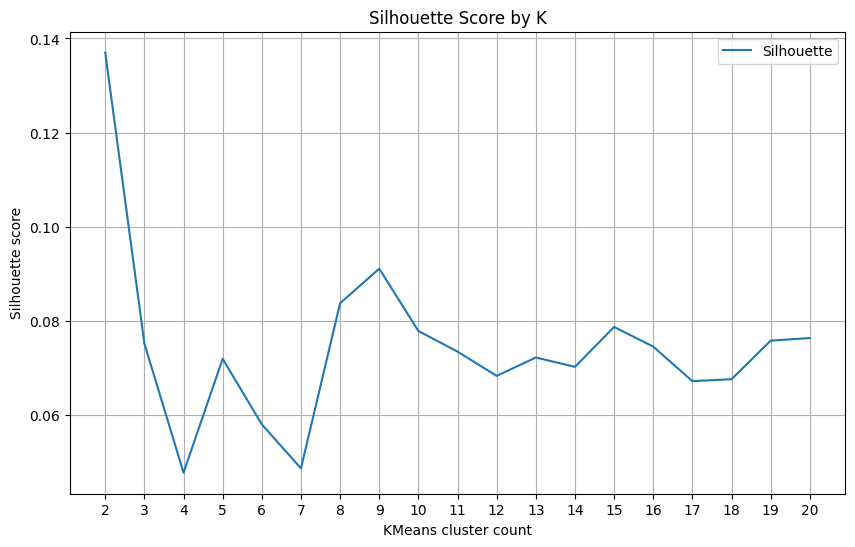

In [131]:
from sklearn.metrics import silhouette_score

cluster_results_km = pd.DataFrame({'K': range(2, 21), 'Silhouette': np.nan})
cluster_results_km.set_index('K', inplace=True)

for k in range(2, 21):
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=42, n_init='auto')
    kmeans.fit(matrix)
    labels = kmeans.labels_
    cluster_results_km.loc[k, 'Silhouette'] = silhouette_score(matrix, labels)

cluster_results_km.plot(
    ylabel='Silhouette score',
    xlabel="KMeans cluster count",
    xticks=range(2, 21),
    figsize=(10, 6),
    title='Silhouette Score by K',
    grid=True,
)

In [139]:
from sklearn.cluster import KMeans

n_clusters = 9

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42, n_init='auto')
kmeans.fit(matrix)
labels = kmeans.labels_
df["cluster"] = labels

df.head(30)

,name,cluster,number,hours,prefix,combined,n_tokens,embedding
0,Course Introduction,5,1.0,1.000000,CEFA,Title: Course Introduction; Description: In th...,6473,"[-0.0039598713628947735, -0.017915276810526848..."
1,Business Ethics,6,2.0,1.000000,CEFA,Title: Business Ethics; Description: In this l...,4952,"[-0.0010442509083077312, -0.026753325015306473..."
3,Introduction to Accounting,3,3.1,1.000000,CEFA,Title: Introduction to Accounting; Description...,5117,"[-0.016149388626217842, -0.002135628368705511,..."
5,Financial Statements - Balance sheet,3,3.3,1.000000,CEFA,Title: Financial Statements - Balance sheet; D...,5512,"[-0.024996846914291382, 0.011464428156614304, ..."
6,Financial Statements - Cash Flow,3,3.4,1.000000,CEFA,Title: Financial Statements - Cash Flow; Descr...,3734,"[-0.03483816981315613, -0.0025355496909469366,..."
8,Analyzing Cash Flow,3,4.0,1.000000,CEFA,Title: Analyzing Cash Flow; Description: The k...,5488,"[-0.030511988326907158, -0.004717483650892973,..."
10,Time Value of Money,5,4.2,1.000000,CEFA,Title: Time Value of Money; Description: The k...,7098,"[-0.020003195852041245, -0.013479584828019142,..."
12,Risk and Return,5,5.0,1.000000,CEFA,Title: Risk and Return; Description: In this v...,6795,"[-0.003653840394690633, -0.02261749468743801, ..."
13,Introduction to Portfolio Risk,5,5.1,1.000000,CEFA,Title: Introduction to Portfolio Risk; Descrip...,4945,"[-0.018398461863398552, -0.012869985774159431,..."
16,Incremental Investment Analysis,5,6.2,1.000000,CEFA,Title: Incremental Investment Analysis; Descri...,7039,"[-0.010401735082268715, -0.012515908107161522,..."


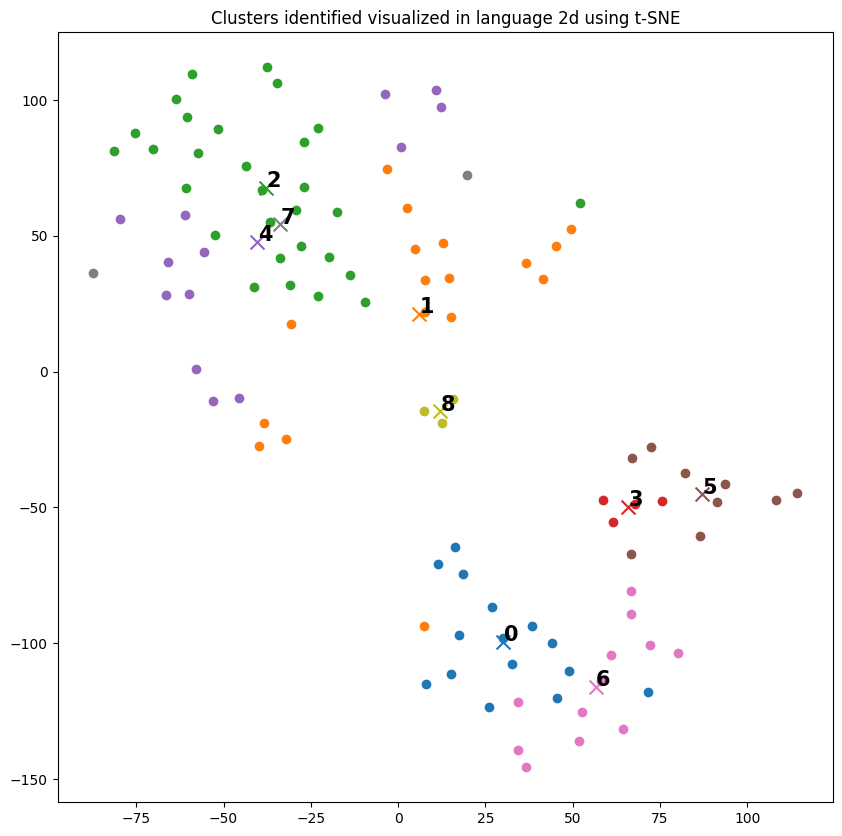

In [147]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

if n_clusters > 10:
  palette = sns.color_palette("tab20", n_clusters).as_hex()
else:
  palette = sns.color_palette("tab10", n_clusters).as_hex()

plt.figure(figsize=(10, 10))

for category, color in enumerate(palette):
  xs = np.array(x)[df.cluster == category]
  ys = np.array(y)[df.cluster == category]
  plt.scatter(xs, ys, color=color, alpha=1)

  avg_x = xs.mean()
  avg_y = ys.mean()

  plt.text(avg_x + 0.15, avg_y + 0.15, category, fontsize=15, fontweight='bold')

  plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")
plt.show()

In [148]:
df.groupby("cluster").size().sort_values(ascending=False)

cluster
2    29
1    17
0    15
4    13
6    12
5     9
3     4
8     3
7     2
dtype: int64

In [142]:
df[['name', 'cluster', 'prefix', 'number']].groupby("cluster").head()

,name,cluster,prefix,number
0,Course Introduction,5,CEFA,1.0
1,Business Ethics,6,CEFA,2.0
3,Introduction to Accounting,3,CEFA,3.1
5,Financial Statements - Balance sheet,3,CEFA,3.3
6,Financial Statements - Cash Flow,3,CEFA,3.4
8,Analyzing Cash Flow,3,CEFA,4.0
10,Time Value of Money,5,CEFA,4.2
12,Risk and Return,5,CEFA,5.0
13,Introduction to Portfolio Risk,5,CEFA,5.1
16,Incremental Investment Analysis,5,CEFA,6.2


In [143]:
# count the number of instances for each unique prefix value
df.groupby("prefix").size().sort_values(ascending=False)

prefix
PM       16
CEFA     14
ACO      10
IP        9
LP-ME     9
NFM       9
OS        7
LPGS      6
NLP       6
IPME      5
ORMF      5
CSLP      4
DEA       3
QSD       1
dtype: int64

In [150]:
df[df.cluster == 7]

,name,cluster,number,hours,prefix,combined,n_tokens,embedding
95,Introduction to Network Flow Models,7,8.0,0.245521,NFM,Title: Introduction to Network Flow Models; De...,118,"[-0.005312740337103605, 0.012432942166924477, ..."
96,Network Flow Models,7,8.1,0.614819,NFM,Title: Network Flow Models; Description: Ident...,710,"[-0.005887497216463089, 0.010028370656073093, ..."


In [151]:
df[df.cluster == 8]

,name,cluster,number,hours,prefix,combined,n_tokens,embedding
78,Introduction to Data Envelopment Analysis,8,5.0,0.200000,DEA,Title: Introduction to Data Envelopment Analys...,177,"[0.00042994116665795445, 0.007690299768000841,..."
79,Data Envelopment Analysis,8,5.1,0.675300,DEA,Title: Data Envelopment Analysis; Description:...,7085,"[-0.01847120001912117, -0.012827222235500813, ..."
80,Data Envelopment Analysis Applications,8,5.2,1.764842,DEA,Title: Data Envelopment Analysis Applications;...,3521,"[-0.01884360983967781, -0.00622345507144928, 0..."


In [152]:
df[df.cluster == 3]

,name,cluster,number,hours,prefix,combined,n_tokens,embedding
3,Introduction to Accounting,3,3.1,1.0,CEFA,Title: Introduction to Accounting; Description...,5117,"[-0.016149388626217842, -0.002135628368705511,..."
5,Financial Statements - Balance sheet,3,3.3,1.0,CEFA,Title: Financial Statements - Balance sheet; D...,5512,"[-0.024996846914291382, 0.011464428156614304, ..."
6,Financial Statements - Cash Flow,3,3.4,1.0,CEFA,Title: Financial Statements - Cash Flow; Descr...,3734,"[-0.03483816981315613, -0.0025355496909469366,..."
8,Analyzing Cash Flow,3,4.0,1.0,CEFA,Title: Analyzing Cash Flow; Description: The k...,5488,"[-0.030511988326907158, -0.004717483650892973,..."
